In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pprint
import pyedflib

project_root = '..'
sys.path.append(project_root)

from sleep.data.loader import load_dataset
from sleep.detection.feeder_dataset import FeederDataset
from sleep.detection.predicted_dataset import PredictedDataset
from sleep.detection import metrics
from sleep.common import constants, pkeys, checks
from sleep.data import utils

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

RESULTS_PATH = os.path.join(project_root, 'results')
SEED_LIST = [123, 234, 345, 456]

In [211]:
ckpt_folder = '20190504_bsf'
task_mode = constants.WN_RECORD
dataset_name = constants.MASS_SS_NAME
seed_id = 1
chosen_thr = 0.5
which_expert = 1
verbose = False

dataset = load_dataset(dataset_name)
all_train_ids = dataset.train_ids
full_ckpt_folder = '%s_%s_train_%s' % (ckpt_folder, task_mode, dataset_name)
ckpt_path = os.path.abspath(os.path.join(
    RESULTS_PATH,
    'predictions_%s' % dataset_name,
    full_ckpt_folder,
    'bsf',
    'seed%d' % seed_id
))
print('Loading from %s' % ckpt_path)
filename = os.path.join(
    ckpt_path,
    'prediction_%s_%s.pkl' % (task_mode, constants.VAL_SUBSET))
with open(filename, 'rb') as handle:
    prediction_val = pickle.load(handle)  # Predicted Dataset
    
# Validation split
_, val_ids = utils.split_ids_list(
    all_train_ids, seed=SEED_LIST[seed_id], verbose=verbose)
# Prepare expert labels
data_val = FeederDataset(
    dataset, val_ids, task_mode, which_expert=which_expert)
# Prepare model predictions
prediction_val.set_probability_threshold(chosen_thr)

print('Val IDs:', data_val.get_ids(), prediction_val.get_ids())

val_ids = data_val.get_ids()

# Get stamps
events_val = data_val.get_stamps()
detections_val = prediction_val.get_stamps()

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Loading from /home/ntapia/Projects/GitNico/sleep-rnn/results/predictions_mass_ss/20190504_bsf_wn_train_mass_ss/bsf/seed1
Val IDs: [3, 9, 17] [3, 9, 17]


In [213]:
sub_idx = 0

subject_id = val_ids[sub_idx]
print('\nSubject ID', subject_id)
events = events_val[sub_idx]
detections = detections_val[sub_idx]
iou_array, idx_array = metrics.matching(events, detections)
n_detections = detections.shape[0]
n_events = events.shape[0]
n_ufn = (idx_array == -1).sum()
n_matched = n_events - n_ufn
n_ufp = n_detections - n_matched
print('Number of events', n_events)
print('Number of detections', n_detections)
print('Number of matched', n_matched)
print('Number of UFP %d, Number of UFN %d' % (n_ufp, n_ufn))
print('Recall', n_matched / n_events)
print('Precision', n_matched / n_detections)
print('F1score', 2*n_matched / (n_events + n_detections))

ufp_idx = [i for i in range(n_detections) if i not in idx_array]
detections_ufp = detections[ufp_idx, :]
centers_ufp = np.mean(detections_ufp, axis=1)
pages_ufp = np.floor(centers_ufp / dataset.page_size).astype(np.int32)
print('Pages of UFP:', pages_ufp)

# Read states for subset of pages
print('\nLoading states')
wn_pages = data_val.get_subject_pages(subject_id)
wn_pages = np.concatenate([[0], wn_pages])
filename = os.path.join(dataset.dataset_dir, 'label', 'state', '01-02-%04d Base.edf' % subject_id)

print('Loaded from %s' % filename)
with pyedflib.EdfReader(filename) as file:
    annotations = file.readAnnotations()
onsets = np.array(annotations[0])

durations = np.round(np.array(annotations[1]))
print('Onsets with durations [s]', np.unique(durations))

stages_str = annotations[2]
stages_dtype = stages_str.dtype
stages_char = [single_annot[-1] for single_annot in stages_str]
total_annots = len(stages_char)
state_key_list = [key for key in np.unique(stages_char) if key != "?"]
unk_key =  "?"

state_dict = {}
for state_key in state_key_list:
    state_idx = np.where([stages_char[i] == state_key for i in range(total_annots)])[0]
    state_dict[state_key] = np.floor(onsets[state_idx] / dataset.page_duration).astype(np.int32)
pages_subset_states = []
for page in wn_pages:
    state_not_found = True
    for state_key in state_key_list:
        if page in state_dict[state_key] and state_not_found:
            pages_subset_states.append(state_key)
            state_not_found = False
    if state_not_found:
        pages_subset_states.append(unk_key)
pages_subset_states = np.asarray(pages_subset_states)

print('Pages states unique values:', np.unique(pages_subset_states))

# Get state of UFP
states_ufp = pages_subset_states[pages_ufp]


Subject ID 3
Number of events 143
Number of detections 117
Number of matched 92
Number of UFP 25, Number of UFN 51
Recall 0.6433566433566433
Precision 0.7863247863247863
F1score 0.7076923076923077
Pages of UFP: [ 117  123  133  139  144  148  320  370  384  384  546  550  572  591
  640  646  683  714  738  947  951  977 1039 1437 1576]

 Loading states
Loaded from /home/ntapia/Projects/GitNico/sleep-rnn/resources/datasets/mass/label/state/01-02-0003 Base.edf
Onsets with durations [s] [20.]
Pages states unique values: ['1' '2' '3' '4' '?' 'R' 'W']


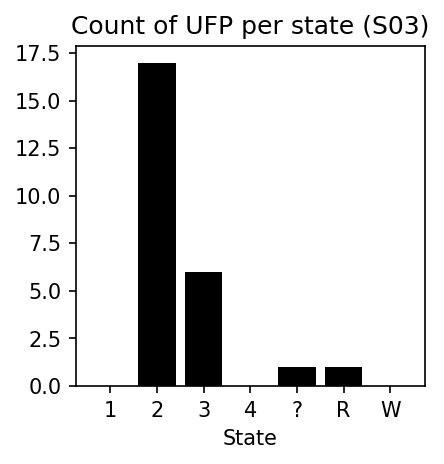

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
ax.set_title('Count of UFP per state (S%02d)' % subject_id)
unique, counts = np.unique(states_ufp, return_counts=True)
for state_key in state_key_list:
    if state_key not in unique:
        unique = np.concatenate([unique, [state_key]])
        counts = np.concatenate([counts, [0]])
sorted_idx = np.argsort(unique)
unique = unique[sorted_idx]
counts = counts[sorted_idx]
ax.bar(unique, counts, width=0.8, bottom=None, facecolor='k')
ax.set_xlabel('State')
plt.show()

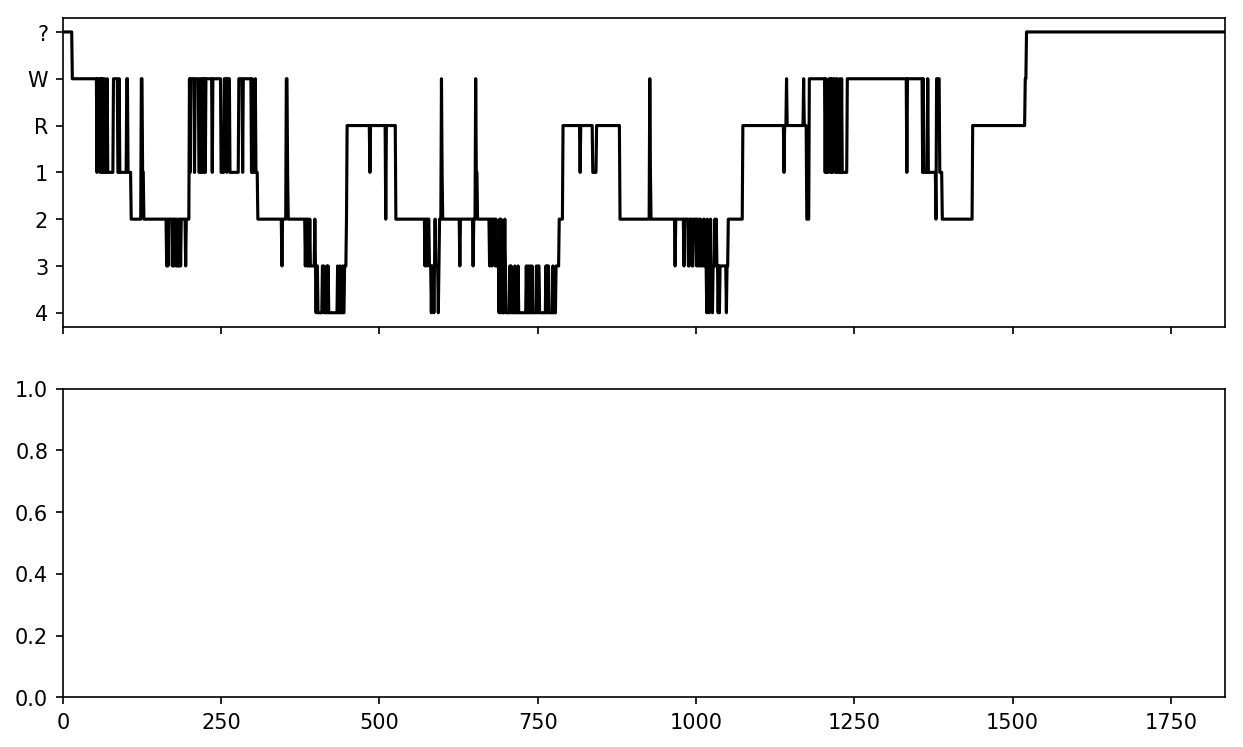

In [226]:
"""
Graficar 

hipnograma de todos los estados
dibujo en donde una raya blanca indique una pagina en donde hay un UFP

"""
numerical_state = np.zeros(pages_subset_states.shape)
numerical_state_values = {
    '1': -1, '2': -2, '3': -3, '4': -4, 'R': 0, 'W': 1, '?': 2
}
for state_key in state_key_list + ['?']:
    np.place(numerical_state, pages_subset_states==state_key, numerical_state_values[state_key])

fig, ax = plt.subplots(2, 1, figsize=(10, 6), dpi=150, sharex=True)
ax[0].plot(numerical_state, color='k')
ax[0].set_yticks([numerical_state_values[my_key] for my_key in numerical_state_values.keys()])
ax[0].set_xlim([0, len(numerical_state)-1])
ax[0].set_yticklabels(state_key_list + ['?'])
plt.show()

In [192]:
numerical_original.shape

(1525,)

In [167]:
state_key

'W'

In [157]:
numerical_state